# Project Analysis: T-ECD Dataset

## 1. Project Overview
In this project, I am performing an **Exploratory Data Analysis (EDA)** on the T-ECD dataset. My goal is to demonstrate how to effectively handle and analyze large-scale transactional data systems.

### My Objectives:
1.  **Data Ingestion**: I need to programmatically download data from Hugging Face and handle the Parquet file format efficiently.
2.  **Data Modeling**: I am separating my analysis into **Static Entities** (like Users and Brands) and **Dynamic Events** (like Transactions) to mirror a real-world data warehouse schema.
3.  **Handling Big Data**: Since the full dataset is too large for memory, I am implementing strategies like partitioning and sampling to make the analysis feasible on a single machine.
4.  **Quality Assurance**: I am using statistical profiling to verify the integrity of the data before using it in downstream models.

### Context
The **T-ECD (Transactional E-Commerce Dataset)** is distributed across many partition files. I wrote this notebook to stitch these partitions together and extract meaningful insights.

In [1]:
# Install necessary libraries
# !pip install huggingface_hub pandas pyarrow ipywidgets matplotlib seaborn

## Authentication
You need a Hugging Face token to access the dataset. 
1. Go to https://huggingface.co/settings/tokens
2. Create a new token (Read access is sufficient)
3. Paste it below when prompted.

In [2]:
from huggingface_hub import login

# login()

## Configuration & Helper Functions

We define global constants to control the data loading process.

In [1]:
from huggingface_hub import hf_hub_download, list_repo_files
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# --- CONFIGURATION ---
REPO_ID = "t-tech/T-ECD"
REPO_TYPE = "dataset"
CACHE_DIR = "dataset_cache"  # Local folder to store downloaded files

# Dataset Paths
DATASET_PATH_SMALL = "dataset/small"
DATASET_PATH_FULL = "dataset/full" # Used for missing payments data

# GLOBAL CONSTANT: How many partitions to load for split datasets (e.g., events)
# Set this to a higher number (e.g., 50 or 100) to analyze more data.
# Set to None to load ALL available partitions (Warning: May run out of RAM in Colab)
DATASET_SMALL_NUM_PARTITIONS_TO_LOAD = 10 
DATASET_FULL_NUM_PARTITIONS_TO_LOAD = 1

TARGET_PARTITION_ID = "01082"  # Matches the start of your Small dataset

def load_remote_parquet(filename, columns_to_exclude=None):
    """
    I use this function to download and load a specific Parquet file.
    
    Implementation Detail:
    - I implemented a check for the local cache first. If the file exists, I skip the download to save time.
    - I chose Parquet because it's column-oriented, which is much faster for the type of analytical queries I'm running compared to CSV.
    """
    print(f"Downloading {filename} to {CACHE_DIR}...")
    try:
        local_path = hf_hub_download(
            repo_id=REPO_ID,
            filename=filename,
            repo_type=REPO_TYPE,
            local_dir=CACHE_DIR,
            local_dir_use_symlinks=False
        )
        # print(f"File cached at: {local_path}")

        if columns_to_exclude:
            import pyarrow.parquet as pq
            # Read schema using read_schema (more reliable than ParquetFile)
            schema = pq.read_schema(local_path)
            # Filter out internal pyarrow columns (those starting with __)
            all_cols = [name for name in schema.names if not name.startswith('__')]
            use_cols = [c for c in all_cols if c not in columns_to_exclude]
            print(f"  Excluding columns: {columns_to_exclude}")
            print(f"  Reading columns: {use_cols}")
            df = pd.read_parquet(local_path, columns=use_cols)
            return df
        
        df = pd.read_parquet(local_path)
        return df
    except Exception as e:
        print(f"Error loading {filename}: {e}")
        return None

def load_dataframe_from_partitions(file_list, limit=DATASET_SMALL_NUM_PARTITIONS_TO_LOAD, columns_to_exclude=None, match_term=None):
    """
    This function handles the complexity of stitching together multiple partition files.
    
    Args:
        limit (int): Number of partitions to load. Set to None to load all partitions.
        match_term (str): If provided, filters files to include only those containing this string (e.g., "01082").
                          Critical for aligning 'Full' datasets with 'Small' datasets.
    """
    if not file_list:
        print("No files provided to load.")
        return None
    
    # 1. Filter by specific partition ID if requested (e.g., "01082")
    if match_term:
        original_count = len(file_list)
        file_list = [f for f in file_list if match_term in f]
        print(f"Filter: Found {len(file_list)} files matching '{match_term}' (out of {original_count})")
        
        if not file_list:
            print(f"WARNING: No files matched '{match_term}'. Returning None.")
            return None

    # Sort files to ensure order (e.g., by date)
    sorted_files = sorted(file_list)
    
    # Apply limit
    if limit is not None:
        files_to_load = sorted_files[:limit]
        print(f"Loading {len(files_to_load)} partitions (out of {len(sorted_files)} available)...")
    else:
        files_to_load = sorted_files
        print(f"Loading ALL {len(files_to_load)} partitions...")

    dfs = []
    for f in files_to_load:
        df = load_remote_parquet(f, columns_to_exclude=columns_to_exclude)
        if df is not None:
            dfs.append(df)
    
    if not dfs:
        return None
    
    print("Concatenating partitions...")
    full_df = pd.concat(dfs, ignore_index=True)
    return full_df
    
def analyze_dataframe(df, name="DataFrame"):
    """
    I created this helper function to standardize my EDA process.
    
    For every dataset I load, I automatically run these checks:
    1.  **Shape**: To see how much data I actually have.
    2.  **Types**: To ensure IDs are strings and metrics are numbers.
    3.  **Missing Values**: To spot data quality issues immediately.
    4.  **Duplicates**: To ensure I don't have redundant records (though I skip this for massive tables to save time).
    5.  **Visualizations**: I plot distributions to understand the data's 'shape' at a glance.
    """
    if df is None:
        print(f"{name} is None, skipping analysis.")
        return

    print(f"\n" + "="*20 + f" ANALYZING: {name} " + "="*20)
    print(f"Shape: {df.shape}")
    
    print("\n1. Head (First 5 rows):")
    display(df.head())
    
    print("\n2. Info (Data Types & Non-Null Counts):")
    df.info()
    
    print("\n3. Describe (Statistical Summary for Numeric Columns):")
    display(df.describe())
    
    print("\n4. Missing Values (NaN Count):")
    missing_counts = df.isnull().sum()
    missing_pcts = df.isnull().mean() * 100
    print(missing_counts)
    print("\nMissing Percentages:")
    print(missing_pcts.round(1).astype(str) + "%")
    
    print("\n5. Duplicates Count:")
    try:
        print(df.duplicated().sum())
    except TypeError:
        print("  Warning: Unable to check for duplicates due to unhashable types (e.g., embeddings).")
        if 'embedding' in df.columns:
            print("  Retrying without 'embedding' column:")
            print(f"  {df.drop(columns=['embedding']).duplicated().sum()}")
    except MemoryError:
        print("  Warning: Unable to check for duplicates due to memory constraints.")
        
    print("\n6. Column Value Counts (Top 5 unique values for object columns):")
    cat_cols = df.select_dtypes(include=['object', 'category', 'string']).columns
    for col in cat_cols:
        if col == "embedding":
            print(f"  Skipping value counts for '{col}' column (performance optimization).")
            continue
        print(f"\nColumn: {col}")
        print(df[col].value_counts().head())

    print("\n7. Visualizations:")

    # Numeric Distributions & Timedelta
    num_cols = df.select_dtypes(include=['number', 'timedelta']).columns
    if len(num_cols) > 0:
        print(f"  - Plotting distributions for numeric/timedelta columns: {list(num_cols)}")
        for col in num_cols:
            # Skip specific columns that cause issues or are not useful distributions
            if "id" in col.lower() and df[col].nunique() > 1000:
                 print(f"    Skipping distribution plot for {col} (likely an ID with high cardinality).")
                 continue
            
            plt.figure(figsize=(8, 4))
            series_to_plot = df[col].dropna()
            
            # Handle timedelta: Convert to total seconds
            if pd.api.types.is_timedelta64_dtype(series_to_plot):
                print(f"    Converting {col} to total seconds for plotting.")
                series_to_plot = series_to_plot.dt.total_seconds()
            
            print(f"    Distribution statistics for {col}:")
            print(series_to_plot.describe())
            
            sns.histplot(series_to_plot, kde=False, bins=30)
            plt.title(f"Distribution of {col}")
            plt.xlabel(col)
            plt.ylabel("Frequency")
            plt.show()

    # Categorical Counts (Top 10)
    if len(cat_cols) > 0:
        print(f"  - Plotting counts for categorical columns: {list(cat_cols)}")
        for col in cat_cols:
            if col == "embedding":
                continue # Skip embedding plots
            if df[col].nunique() > 50: # Skip if too many unique values
                print(f"    Skipping plot for {col} (too many unique values: {df[col].nunique()})")
                continue
            plt.figure(figsize=(10, 5))
            # Use full dataframe for determining the top 10 order to be accurate
            top_10_counts = df[col].value_counts().iloc[:10]
            print(f"    Top 10 counts for {col}:")
            print(top_10_counts)
            sns.countplot(y=col, data=df, order=top_10_counts.index)
            plt.title(f"Top 10 Counts for {col}")
            plt.xlabel("Count")
            plt.ylabel(col)
            plt.show()
    
    print("\n" + "="*60 + "\n")

## 1. Explore Repository & Index Files
We list all files once and categorize them to avoid repeated API calls.

In [4]:
all_files = list_repo_files(repo_id=REPO_ID, repo_type=REPO_TYPE)

# Categorize files by domain and type for easy access
dataset_files = defaultdict(list)

for f in all_files:
    if f.endswith(".pq"):
        # Example f: dataset/small/retail/events/01082.pq
        # Key: dataset/small/retail/events
        dirname = os.path.dirname(f).replace("\\", "/") # Normalize path separators
        dataset_files[dirname].append(f)

print("File Index Created. Available Directories:")
for d in sorted(dataset_files.keys()):
    count = len(dataset_files[d])
    print(f" - {d} ({count} files)")

File Index Created. Available Directories:
 - dataset/full (2 files)
 - dataset/full/marketplace (1 files)
 - dataset/full/marketplace/events (793 files)
 - dataset/full/offers (1 files)
 - dataset/full/offers/events (944 files)
 - dataset/full/payments/events (1309 files)
 - dataset/full/payments/receipts (1017 files)
 - dataset/full/retail (1 files)
 - dataset/full/retail/events (579 files)
 - dataset/full/reviews (1309 files)
 - dataset/small (2 files)
 - dataset/small/marketplace (1 files)
 - dataset/small/marketplace/events (227 files)
 - dataset/small/offers (1 files)
 - dataset/small/offers/events (227 files)
 - dataset/small/retail (1 files)
 - dataset/small/retail/events (227 files)
 - dataset/small/reviews (227 files)


## 2. Analysis of Static Entities
I am starting with the **Dimension Tables** (Users and Brands). These describe the entities in the system.
I treat these differently because they are static (don't change often) and are small enough to be stored as single files, unlike the event logs.

c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(



==================== ANALYZING: Users Data ====================
Shape: (3500000, 3)

1. Head (First 5 rows):


,user_id,socdem_cluster,region
0,77309558,21.0,2.0
1,72517894,10.0,90.0
2,86699708,9.0,9.0
3,54241043,17.0,58.0
4,23591057,17.0,4.0



2. Info (Data Types & Non-Null Counts):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500000 entries, 0 to 3499999
Data columns (total 3 columns):
 #   Column          Dtype  
---  ------          -----  
 0   user_id         uint64 
 1   socdem_cluster  float64
 2   region          float64
dtypes: float64(2), uint64(1)
memory usage: 80.1 MB

3. Describe (Statistical Summary for Numeric Columns):


,user_id,socdem_cluster,region
count,3.500000e+06,3.494847e+06,3.441083e+06
mean,4.497132e+07,1.281904e+01,4.044861e+01
std,2.596685e+07,6.463649e+00,2.927570e+01
min,3.000000e+00,0.000000e+00,0.000000e+00
25%,2.249775e+07,9.000000e+00,1.500000e+01
50%,4.496408e+07,1.200000e+01,3.700000e+01
75%,6.746539e+07,1.900000e+01,6.300000e+01
max,8.991871e+07,2.100000e+01,9.000000e+01



4. Missing Values (NaN Count):
user_id               0
socdem_cluster     5153
region            58917
dtype: int64

Missing Percentages:
user_id           0.0%
socdem_cluster    0.1%
region            1.7%
dtype: object

5. Duplicates Count:
0

6. Column Value Counts (Top 5 unique values for object columns):

7. Visualizations:
  - Plotting distributions for numeric/timedelta columns: ['user_id', 'socdem_cluster', 'region']
    Skipping distribution plot for user_id (likely an ID with high cardinality).
    Distribution statistics for socdem_cluster:
count    3.494847e+06
mean     1.281904e+01
std      6.463649e+00
min      0.000000e+00
25%      9.000000e+00
50%      1.200000e+01
75%      1.900000e+01
max      2.100000e+01
Name: socdem_cluster, dtype: float64


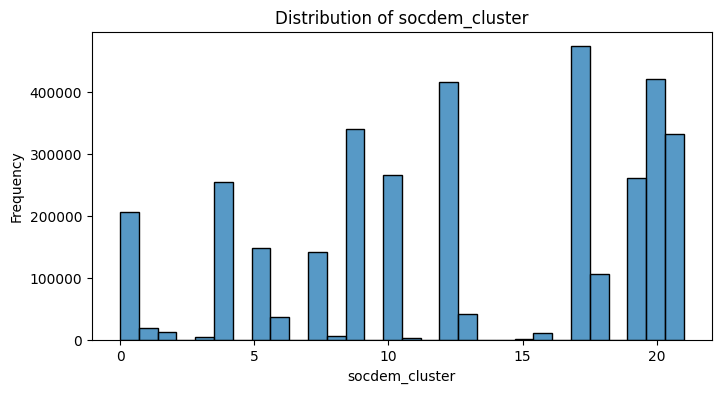

    Distribution statistics for region:
count    3.441083e+06
mean     4.044861e+01
std      2.927570e+01
min      0.000000e+00
25%      1.500000e+01
50%      3.700000e+01
75%      6.300000e+01
max      9.000000e+01
Name: region, dtype: float64


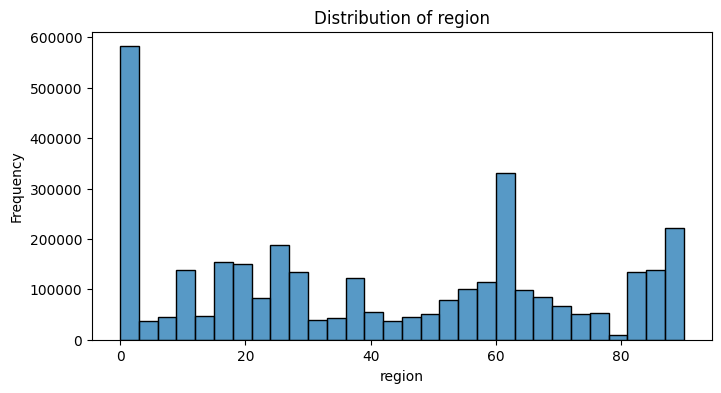

In [5]:
# --- USERS ---
users_path = f"{DATASET_PATH_SMALL}/users.pq"
df_users = load_remote_parquet(users_path)
analyze_dataframe(df_users, "Users Data")

In [6]:
# --- BRANDS ---
brands_path = f"{DATASET_PATH_SMALL}/brands.pq"
df_brands = load_remote_parquet(brands_path)

# Handle broken brands file (empty embeddings)
if df_brands is None:
    print("Attempting to load Brands without 'embedding' column due to schema error...")
    local_path = f"{CACHE_DIR}/{brands_path}"
    if os.path.exists(local_path):
        try:
            df_brands = pd.read_parquet(local_path, columns=['brand_id'])
            print("Successfully loaded Brands data (excluding embeddings).")
        except Exception as e:
            print(f"Fallback load failed: {e}")

analyze_dataframe(df_brands, "Brands Data")

c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


Error loading dataset/small/brands.pq: Expected all lists to be of size=300 but index 1 had size=0
Attempting to load Brands without 'embedding' column due to schema error...
Successfully loaded Brands data (excluding embeddings).

==================== ANALYZING: Brands Data ====================
Shape: (24513, 1)

1. Head (First 5 rows):


,brand_id
0,4
1,34
2,45
3,46
4,51



2. Info (Data Types & Non-Null Counts):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24513 entries, 0 to 24512
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   brand_id  24513 non-null  uint64
dtypes: uint64(1)
memory usage: 191.6 KB

3. Describe (Statistical Summary for Numeric Columns):


,brand_id
count,24513.000000
mean,125964.523233
std,72479.531826
min,4.000000
25%,63256.000000
50%,126363.000000
75%,188300.000000
max,251381.000000



4. Missing Values (NaN Count):
brand_id    0
dtype: int64

Missing Percentages:
brand_id    0.0%
dtype: object

5. Duplicates Count:
46

6. Column Value Counts (Top 5 unique values for object columns):

7. Visualizations:
  - Plotting distributions for numeric/timedelta columns: ['brand_id']
    Skipping distribution plot for brand_id (likely an ID with high cardinality).




## 3. Retail Domain Analysis
Now I am analyzing the Retail domain. This introduces **Fact Tables** (Events).

*   **Items**: Product details.
*   **Events**: User actions (views, purchases).

**Note on Event Data:**
The event data is partitioned by time because it is high-volume. I need to load and join these partitions to get a complete picture.

c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(



==================== ANALYZING: Retail Items ====================
Shape: (250171, 6)

1. Head (First 5 rows):


,item_id,brand_id,category,subcategory,price,embedding
0,fmcg_10,65693,Office Supplies and Educational Materials,Stationery Paper,-4.406018,"[-0.13557312, 0.049446248, -0.018282967, 0.025..."
1,fmcg_10000,146468,Cleaning Supplies and Everyday Household Items,Cleaning and Detergent Products,-4.205185,"[-0.043275375, -0.035317067, 0.0033219394, -0...."
2,fmcg_1000006,37799,None,None,-4.463660,"[-0.083411045, 0.049153276, -0.08736873, 0.075..."
3,fmcg_1000008,240838,Children's Products and Childcare Items,Food Products,-5.138377,"[-0.055184077, 0.02342301, 0.03789554, 0.11559..."
4,fmcg_1000017,240838,Foodstuffs and Beverages,Sweet Desserts and Confectionery,-3.980383,"[-0.052520722, -0.0063896044, -0.011138491, 0...."



2. Info (Data Types & Non-Null Counts):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250171 entries, 0 to 250170
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   item_id      250171 non-null  object 
 1   brand_id     250171 non-null  uint64 
 2   category     240586 non-null  object 
 3   subcategory  240586 non-null  object 
 4   price        223682 non-null  float64
 5   embedding    250171 non-null  object 
dtypes: float64(1), object(4), uint64(1)
memory usage: 11.5+ MB

3. Describe (Statistical Summary for Numeric Columns):


,brand_id,price
count,250171.000000,223682.000000
mean,118619.469799,-3.768593
std,83797.032762,1.324611
min,25989.000000,-10.000000
25%,37799.000000,-4.793809
50%,65693.000000,-3.875122
75%,240838.000000,-2.924246
max,240838.000000,7.740092



4. Missing Values (NaN Count):
item_id            0
brand_id           0
category        9585
subcategory     9585
price          26489
embedding          0
dtype: int64

Missing Percentages:
item_id         0.0%
brand_id        0.0%
category        3.8%
subcategory     3.8%
price          10.6%
embedding       0.0%
dtype: object

5. Duplicates Count:
  Retrying without 'embedding' column:
  0

6. Column Value Counts (Top 5 unique values for object columns):

Column: item_id
item_id
fmcg_999994     1
fmcg_10         1
fmcg_10000      1
fmcg_1000006    1
fmcg_1000008    1
Name: count, dtype: int64

Column: category
category
Foodstuffs and Beverages                                     160128
Cosmetics, Personal Care, and Health Maintenance Products     22998
Home Improvement and Countryside Retreat Essentials           17738
Children's Products and Childcare Items                        8339
Cleaning Supplies and Everyday Household Items                 7731
Name: count, dtype: int64

C

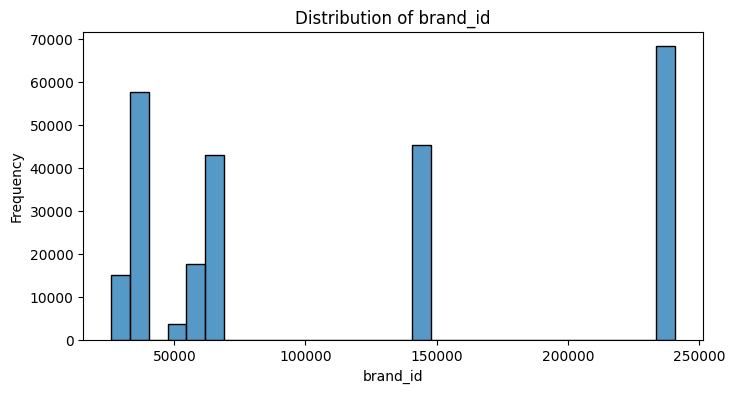

    Distribution statistics for price:
count    223682.000000
mean         -3.768593
std           1.324611
min         -10.000000
25%          -4.793809
50%          -3.875122
75%          -2.924246
max           7.740092
Name: price, dtype: float64


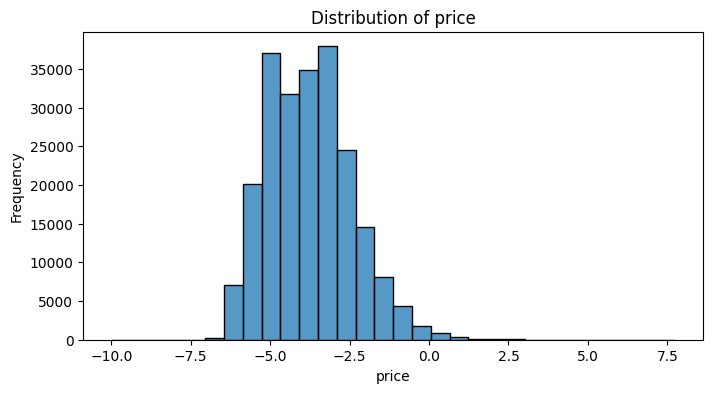

  - Plotting counts for categorical columns: ['item_id', 'category', 'subcategory', 'embedding']
    Skipping plot for item_id (too many unique values: 250171)
    Top 10 counts for category:
category
Foodstuffs and Beverages                                     160128
Cosmetics, Personal Care, and Health Maintenance Products     22998
Home Improvement and Countryside Retreat Essentials           17738
Children's Products and Childcare Items                        8339
Cleaning Supplies and Everyday Household Items                 7731
Outerwear, Casual Apparel, and Specialized Workwear            4162
Pet Supplies: Food, Accessories, and Grooming Products         3710
Other                                                          3155
Office Supplies and Educational Materials                      2983
Fashion Accessories, Tech Add-ons, and Style Enhancements      1810
Name: count, dtype: int64


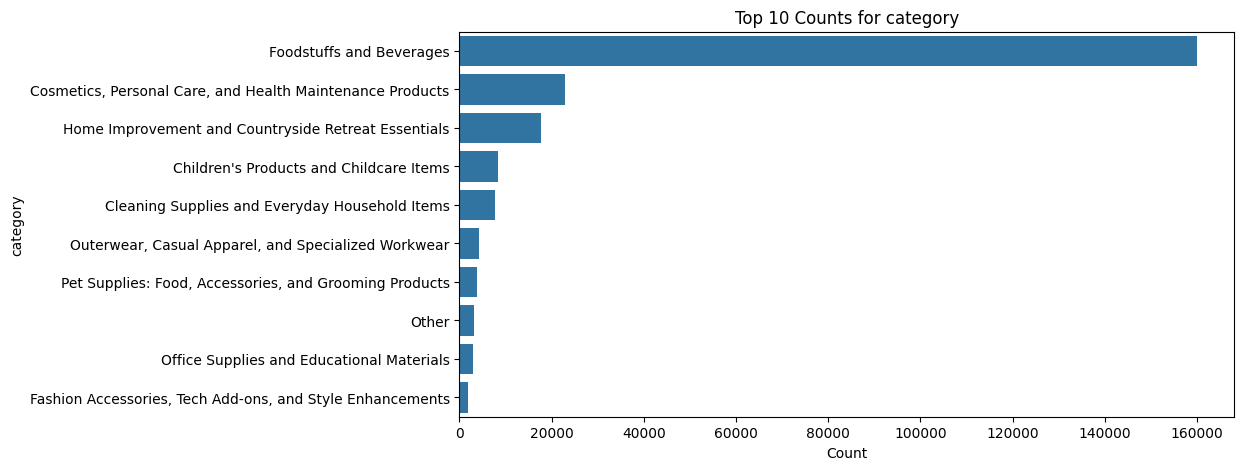

    Skipping plot for subcategory (too many unique values: 174)




In [7]:
# --- RETAIL ITEMS ---
retail_items_path = f"{DATASET_PATH_SMALL}/retail/items.pq"
df_retail_items = load_remote_parquet(retail_items_path)
analyze_dataframe(df_retail_items, "Retail Items")

Loading 10 partitions (out of 227 available)...


c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


Concatenating partitions...

==================== ANALYZING: Retail Events (Joined) ====================
Shape: (4128330, 6)

1. Head (First 5 rows):


,timestamp,user_id,item_id,subdomain,action_type,os
0,1082 days 00:00:00.326593,65070494,fmcg_607128,catalog,view,android
1,1082 days 00:00:00.334152,25095614,fmcg_40462,catalog,view,android
2,1082 days 00:00:00.370722,38969384,fmcg_327866,catalog,view,android
3,1082 days 00:00:00.613473,2266567,fmcg_965886,search,view,android
4,1082 days 00:00:01.152587,25095614,fmcg_576561,catalog,view,android



2. Info (Data Types & Non-Null Counts):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4128330 entries, 0 to 4128329
Data columns (total 6 columns):
 #   Column       Dtype          
---  ------       -----          
 0   timestamp    timedelta64[us]
 1   user_id      uint64         
 2   item_id      object         
 3   subdomain    object         
 4   action_type  object         
 5   os           object         
dtypes: object(4), timedelta64[us](1), uint64(1)
memory usage: 189.0+ MB

3. Describe (Statistical Summary for Numeric Columns):


,timestamp,user_id
count,4128330,4.128330e+06
mean,1087 days 05:10:42.463666,4.396324e+07
std,2 days 19:13:37.927059,2.523998e+07
min,1082 days 00:00:00.326593,4.420600e+04
25%,1085 days 03:43:19.800110,2.290980e+07
50%,1087 days 10:22:47.352846,4.097742e+07
75%,1089 days 12:17:11.082369,6.532290e+07
max,1091 days 23:59:59.914024,8.991361e+07



4. Missing Values (NaN Count):
timestamp      0
user_id        0
item_id        0
subdomain      0
action_type    0
os             0
dtype: int64

Missing Percentages:
timestamp      0.0%
user_id        0.0%
item_id        0.0%
subdomain      0.0%
action_type    0.0%
os             0.0%
dtype: object

5. Duplicates Count:
0

6. Column Value Counts (Top 5 unique values for object columns):

Column: item_id
item_id
fmcg_922936    3491
fmcg_9530      3161
fmcg_995990    2734
fmcg_594395    2729
fmcg_849756    2702
Name: count, dtype: int64

Column: subdomain
subdomain
catalog    3757363
search      286066
main         54314
item         18809
cart         11778
Name: count, dtype: int64

Column: action_type
action_type
view             4010662
added-to-cart      71312
click              46356
Name: count, dtype: int64

Column: os
os
android    4025565
ios         102765
Name: count, dtype: int64

7. Visualizations:
  - Plotting distributions for numeric/timedelta columns: ['timestamp', '

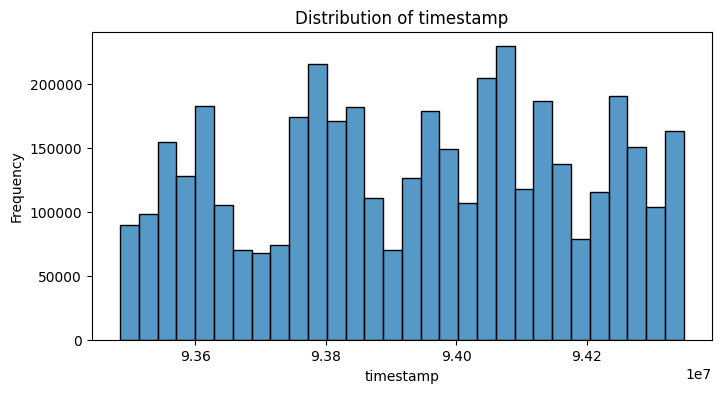

    Skipping distribution plot for user_id (likely an ID with high cardinality).
  - Plotting counts for categorical columns: ['item_id', 'subdomain', 'action_type', 'os']
    Skipping plot for item_id (too many unique values: 75157)
    Top 10 counts for subdomain:
subdomain
catalog    3757363
search      286066
main         54314
item         18809
cart         11778
Name: count, dtype: int64


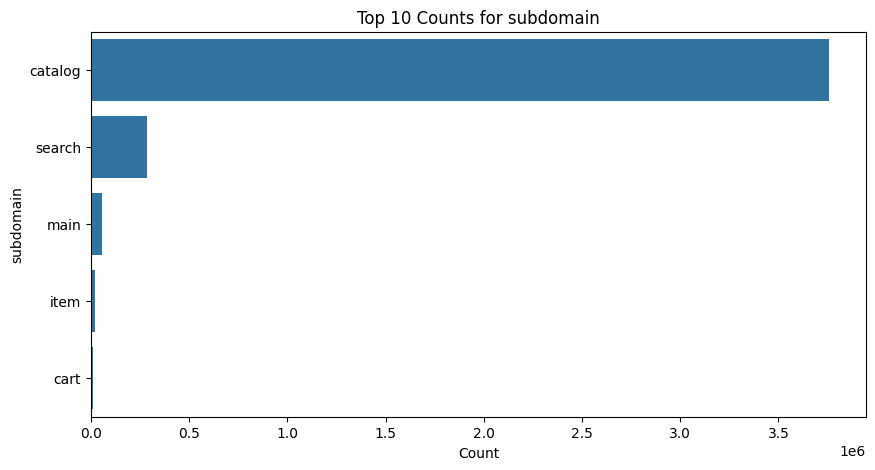

    Top 10 counts for action_type:
action_type
view             4010662
added-to-cart      71312
click              46356
Name: count, dtype: int64


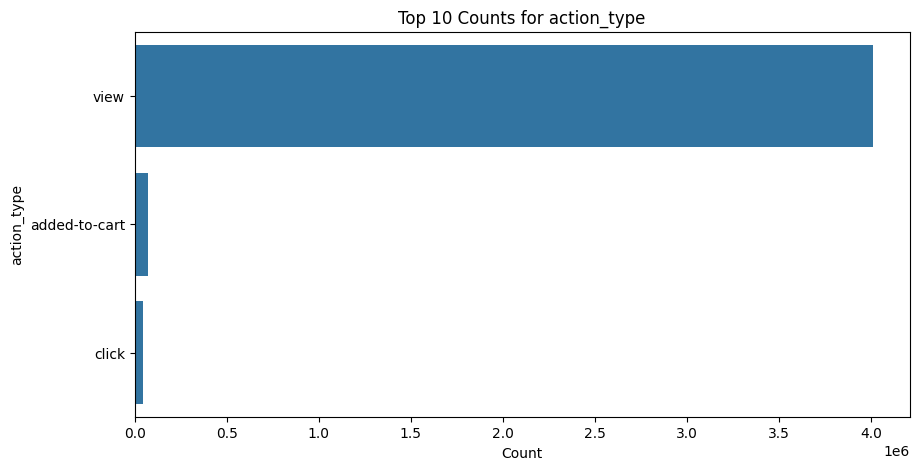

    Top 10 counts for os:
os
android    4025565
ios         102765
Name: count, dtype: int64


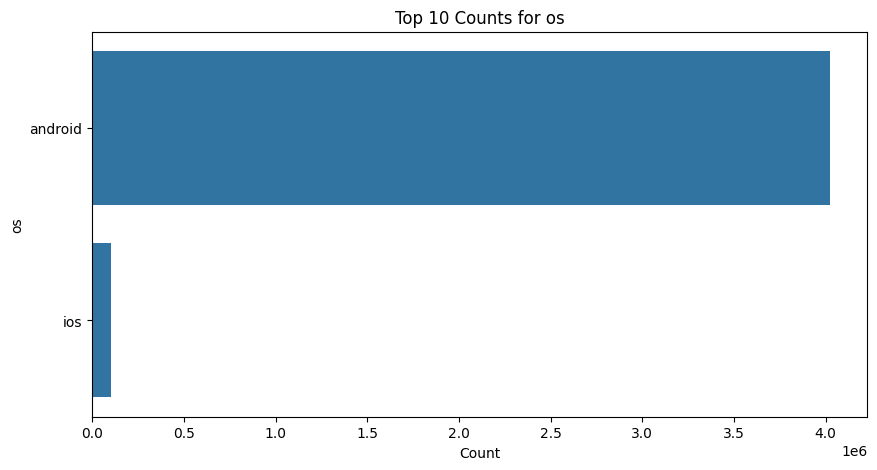

In [8]:
# --- RETAIL EVENTS ---
retail_events_dir = f"{DATASET_PATH_SMALL}/retail/events"
retail_event_files = dataset_files.get(retail_events_dir, [])

df_retail_events = load_dataframe_from_partitions(retail_event_files, limit=DATASET_SMALL_NUM_PARTITIONS_TO_LOAD)
analyze_dataframe(df_retail_events, "Retail Events (Joined)")

## 4. Marketplace Domain Analysis
Contains `items` (static) and `events` (partitioned).

c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


  Excluding columns: ['embedding']
  Reading columns: ['item_id', 'brand_id', 'category', 'subcategory', 'price']

==================== ANALYZING: Marketplace Items ====================
Shape: (2325409, 5)

1. Head (First 5 rows):


,item_id,brand_id,category,subcategory,price
0,nfmcg_10000001,137356,None,None,6.063640
1,nfmcg_10000012,53389,None,None,0.960436
2,nfmcg_1000002,34153,"Fashion Accessories, Tech Add-ons, and Style E...","Hats, Scarves, and Shawls",-1.793113
3,nfmcg_10000034,39543,None,None,3.416755
4,nfmcg_10000039,82320,"Fashion Accessories, Tech Add-ons, and Style E...",Jewelry and Costume Jewelry,4.293433



2. Info (Data Types & Non-Null Counts):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2325409 entries, 0 to 2325408
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   item_id      object 
 1   brand_id     uint64 
 2   category     object 
 3   subcategory  object 
 4   price        float64
dtypes: float64(1), object(3), uint64(1)
memory usage: 88.7+ MB

3. Describe (Statistical Summary for Numeric Columns):


,brand_id,price
count,2.325409e+06,2.322527e+06
mean,1.338569e+05,4.898040e-01
std,7.211351e+04,2.455037e+00
min,3.138000e+03,-1.000000e+01
25%,5.291700e+04,-1.219742e+00
50%,1.373560e+05,4.257582e-01
75%,2.062820e+05,2.194015e+00
max,2.510450e+05,1.000000e+01



4. Missing Values (NaN Count):
item_id              0
brand_id             0
category        966395
subcategory    1233023
price             2882
dtype: int64

Missing Percentages:
item_id         0.0%
brand_id        0.0%
category       41.6%
subcategory    53.0%
price           0.1%
dtype: object

5. Duplicates Count:
0

6. Column Value Counts (Top 5 unique values for object columns):

Column: item_id
item_id
nfmcg_9999995    1
nfmcg_999951     1
nfmcg_9999516    1
nfmcg_9999518    1
nfmcg_999953     1
Name: count, dtype: int64

Column: category
category
Miscellaneous Goods (Uncategorized)                          266146
Cosmetics, Personal Care, and Health Maintenance Products    188412
Fashion Accessories, Tech Add-ons, and Style Enhancements    167811
Outerwear, Casual Apparel, and Specialized Workwear          153223
Footwear of All Types                                        103680
Name: count, dtype: int64

Column: subcategory
subcategory
Jewelry and Costume Jewelry       997

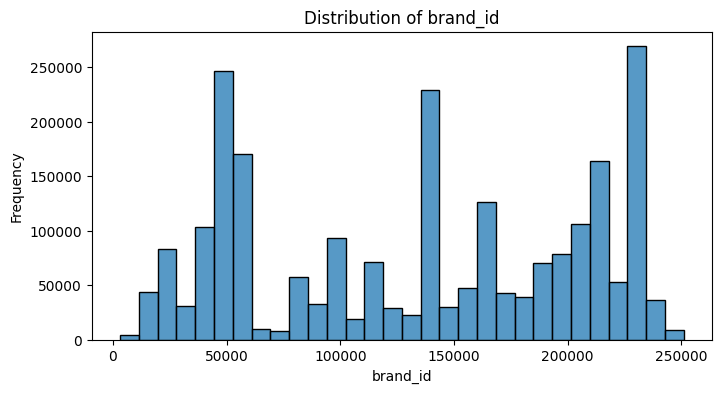

    Distribution statistics for price:
count    2.322527e+06
mean     4.898040e-01
std      2.455037e+00
min     -1.000000e+01
25%     -1.219742e+00
50%      4.257582e-01
75%      2.194015e+00
max      1.000000e+01
Name: price, dtype: float64


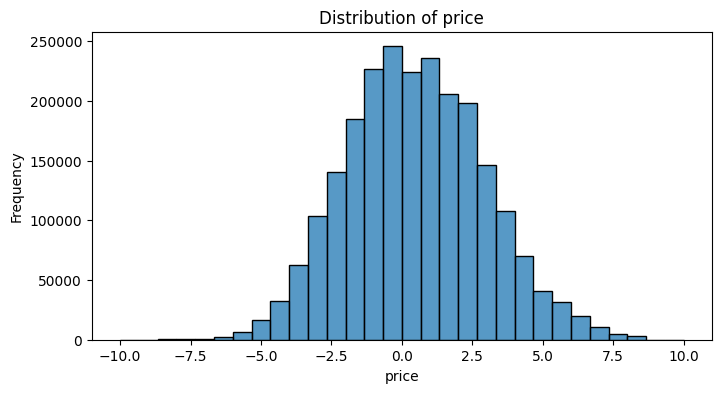

  - Plotting counts for categorical columns: ['item_id', 'category', 'subcategory']
    Skipping plot for item_id (too many unique values: 2325409)
    Top 10 counts for category:
category
Miscellaneous Goods (Uncategorized)                            266146
Cosmetics, Personal Care, and Health Maintenance Products      188412
Fashion Accessories, Tech Add-ons, and Style Enhancements      167811
Outerwear, Casual Apparel, and Specialized Workwear            153223
Footwear of All Types                                          103680
Electronic Devices and Gadgets                                  84282
Home Improvement and Countryside Retreat Essentials             83707
Construction and Renovation Materials, Tools, and Equipment     83584
Home/Office Furniture and Interior Decor                        64919
Household Electrical Appliances                                 61762
Name: count, dtype: int64


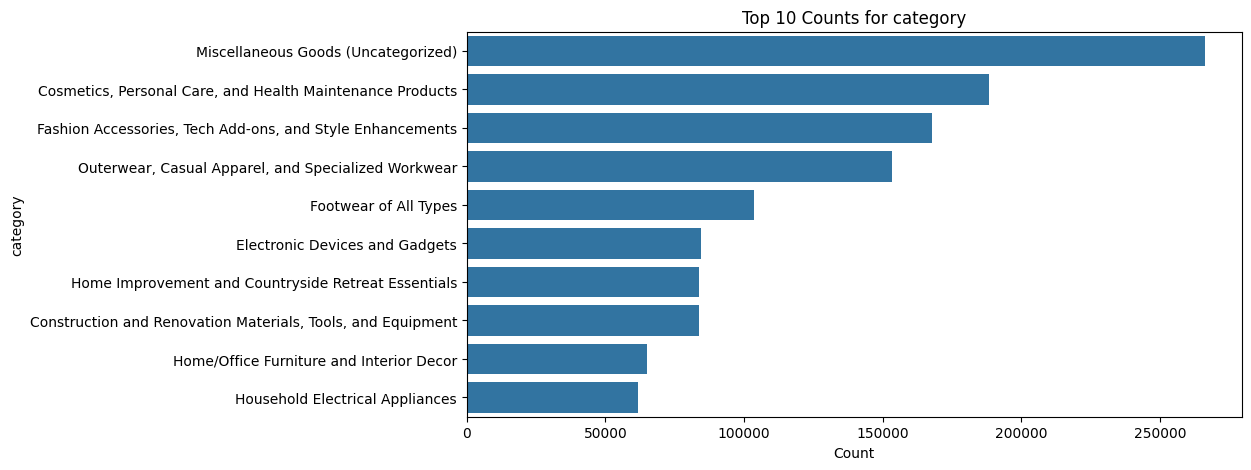

    Skipping plot for subcategory (too many unique values: 192)




In [3]:
# --- MARKETPLACE ITEMS ---
mp_items_path = f"{DATASET_PATH_SMALL}/marketplace/items.pq"
df_mp_items = load_remote_parquet(mp_items_path, columns_to_exclude=["embedding"])
analyze_dataframe(df_mp_items, "Marketplace Items")

Loading 10 partitions (out of 227 available)...


c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


Concatenating partitions...

==================== ANALYZING: Marketplace Events (Joined) ====================
Shape: (5081920, 6)

1. Head (First 5 rows):


,timestamp,user_id,item_id,subdomain,action_type,os
0,1082 days 00:00:00.089901,59328774,nfmcg_14777696,u2i,view,android
1,1082 days 00:00:00.163483,66295302,nfmcg_26098539,catalog,view,android
2,1082 days 00:00:00.864625,37542104,nfmcg_10840247,u2i,view,android
3,1082 days 00:00:00.889192,35193548,nfmcg_8040572,catalog,view,android
4,1082 days 00:00:00.936008,27256137,nfmcg_6770239,catalog,view,android



2. Info (Data Types & Non-Null Counts):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5081920 entries, 0 to 5081919
Data columns (total 6 columns):
 #   Column       Dtype          
---  ------       -----          
 0   timestamp    timedelta64[us]
 1   user_id      uint64         
 2   item_id      object         
 3   subdomain    object         
 4   action_type  object         
 5   os           object         
dtypes: object(4), timedelta64[us](1), uint64(1)
memory usage: 232.6+ MB

3. Describe (Statistical Summary for Numeric Columns):


,timestamp,user_id
count,5081920,5.081920e+06
mean,1087 days 00:25:12.305255,4.518327e+07
std,2 days 21:40:08.851246,2.599683e+07
min,1082 days 00:00:00.089901,2.220000e+02
25%,1084 days 11:48:56.376465,2.257934e+07
50%,1086 days 22:38:52.657100,4.544741e+07
75%,1089 days 13:46:57.303868,6.769520e+07
max,1091 days 23:59:58.906234,8.991870e+07



4. Missing Values (NaN Count):
timestamp         0
user_id           0
item_id           0
subdomain      2138
action_type       0
os                0
dtype: int64

Missing Percentages:
timestamp      0.0%
user_id        0.0%
item_id        0.0%
subdomain      0.0%
action_type    0.0%
os             0.0%
dtype: object

5. Duplicates Count:
0

6. Column Value Counts (Top 5 unique values for object columns):

Column: item_id
item_id
nfmcg_13757063    110595
nfmcg_5205476      62365
nfmcg_20114920     55200
nfmcg_19030396     51993
nfmcg_22992567     51582
Name: count, dtype: int64

Column: subdomain
subdomain
u2i        3266328
other       724828
catalog     648943
search      384034
i2i          55649
Name: count, dtype: int64

Column: action_type
action_type
view        4915404
click        141391
clickout      22987
like           2138
Name: count, dtype: int64

Column: os
os
android    4206903
ios         871601
other         3416
Name: count, dtype: int64

7. Visualizations:
  - Pl

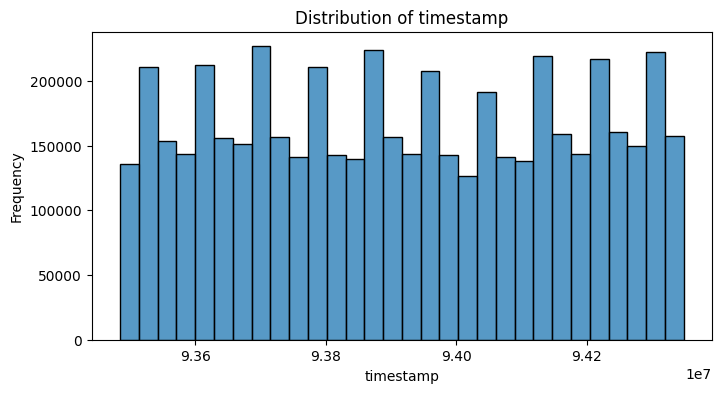

    Skipping distribution plot for user_id (likely an ID with high cardinality).
  - Plotting counts for categorical columns: ['item_id', 'subdomain', 'action_type', 'os']
    Skipping plot for item_id (too many unique values: 241830)
    Top 10 counts for subdomain:
subdomain
u2i        3266328
other       724828
catalog     648943
search      384034
i2i          55649
Name: count, dtype: int64


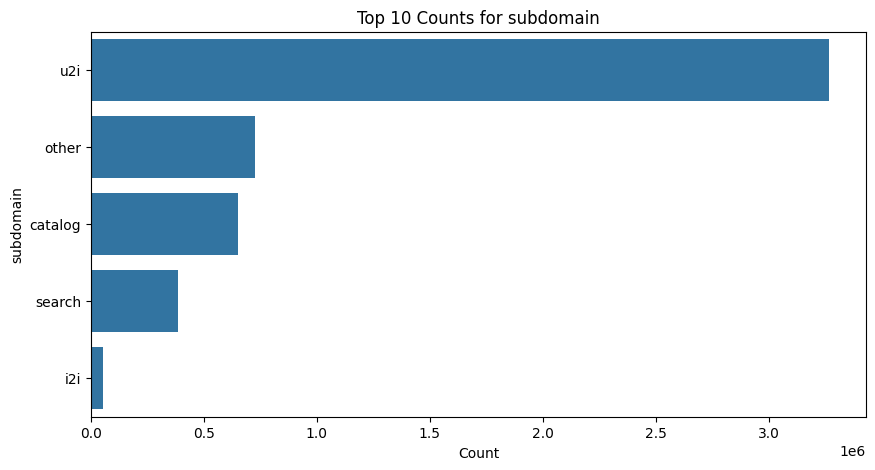

    Top 10 counts for action_type:
action_type
view        4915404
click        141391
clickout      22987
like           2138
Name: count, dtype: int64


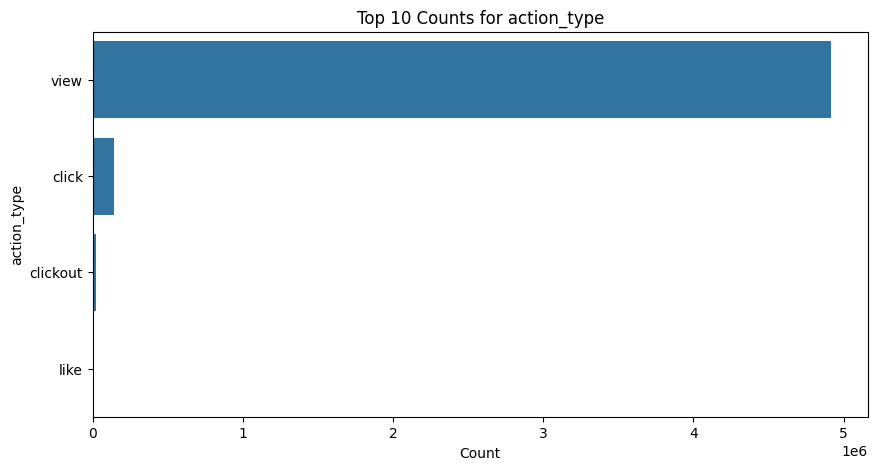

    Top 10 counts for os:
os
android    4206903
ios         871601
other         3416
Name: count, dtype: int64


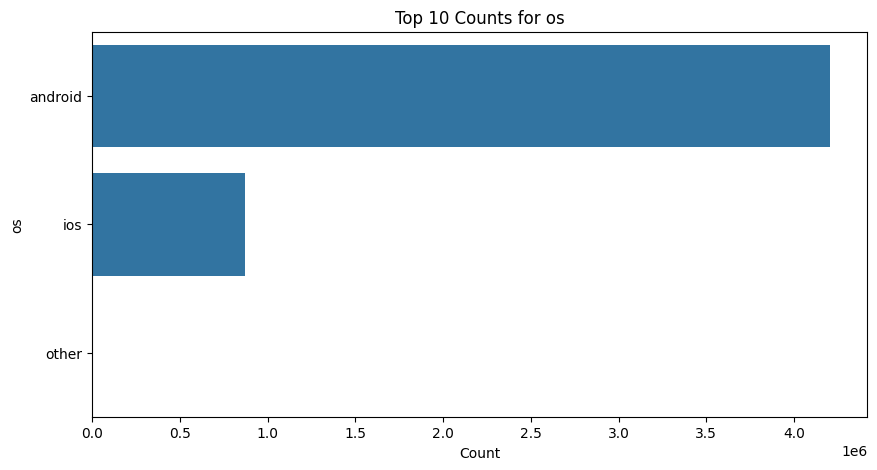

In [10]:
# --- MARKETPLACE EVENTS ---
mp_events_dir = f"{DATASET_PATH_SMALL}/marketplace/events"
mp_event_files = dataset_files.get(mp_events_dir, [])

df_mp_events = load_dataframe_from_partitions(mp_event_files, limit=DATASET_SMALL_NUM_PARTITIONS_TO_LOAD)
analyze_dataframe(df_mp_events, "Marketplace Events (Joined)")

## 5. Offers Domain Analysis
Contains `items` (static) and `events` (partitioned).

In [11]:
# --- OFFERS ITEMS ---
offers_items_path = f"{DATASET_PATH_SMALL}/offers/items.pq"
df_offers_items = load_remote_parquet(offers_items_path)
analyze_dataframe(df_offers_items, "Offers Items")

c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(



==================== ANALYZING: Offers Items ====================
Shape: (22368, 3)

1. Head (First 5 rows):


,item_id,brand_id,embedding
0,offer_1000,25974.0,"[0.01245058, -0.006554137, 0.008180908, -0.065..."
1,offer_10001,233535.0,"[0.08430327, 0.0042775664, -0.06471029, -0.089..."
2,offer_10010,237081.0,"[0.026309866, 0.07163039, 0.035467107, -0.1206..."
3,offer_10011,139056.0,"[0.04429229, 0.028968437, 0.023935385, -0.0890..."
4,offer_10019,11463.0,"[0.07399447, 0.055166934, 0.023564236, -0.0698..."



2. Info (Data Types & Non-Null Counts):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22368 entries, 0 to 22367
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   item_id    22368 non-null  object 
 1   brand_id   21826 non-null  float64
 2   embedding  22368 non-null  object 
dtypes: float64(1), object(2)
memory usage: 524.4+ KB

3. Describe (Statistical Summary for Numeric Columns):


,brand_id
count,21826.000000
mean,125055.585723
std,73032.772814
min,87.000000
25%,64692.000000
50%,121805.000000
75%,187727.000000
max,251377.000000



4. Missing Values (NaN Count):
item_id        0
brand_id     542
embedding      0
dtype: int64

Missing Percentages:
item_id      0.0%
brand_id     2.4%
embedding    0.0%
dtype: object

5. Duplicates Count:
  Retrying without 'embedding' column:
  0

6. Column Value Counts (Top 5 unique values for object columns):

Column: item_id
item_id
offer_9860    1
offer_9863    1
offer_9864    1
offer_9866    1
offer_9867    1
Name: count, dtype: int64
  Skipping value counts for 'embedding' column (performance optimization).

7. Visualizations:
  - Plotting distributions for numeric/timedelta columns: ['brand_id']
    Skipping distribution plot for brand_id (likely an ID with high cardinality).
  - Plotting counts for categorical columns: ['item_id', 'embedding']
    Skipping plot for item_id (too many unique values: 22368)




Loading 10 partitions (out of 227 available)...


c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


Concatenating partitions...

==================== ANALYZING: Offers Events (Joined) ====================
Shape: (30475441, 4)

1. Head (First 5 rows):


,timestamp,user_id,item_id,action_type
0,1082 days 00:00:00.126754,20110833,offer_83661,seen
1,1082 days 00:00:00.143308,36541803,offer_81670,seen
2,1082 days 00:00:00.157553,34286733,offer_42637,seen
3,1082 days 00:00:00.160743,70030166,offer_787,seen
4,1082 days 00:00:00.165194,40343780,offer_32005,seen



2. Info (Data Types & Non-Null Counts):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30475441 entries, 0 to 30475440
Data columns (total 4 columns):
 #   Column       Dtype          
---  ------       -----          
 0   timestamp    timedelta64[us]
 1   user_id      uint64         
 2   item_id      object         
 3   action_type  object         
dtypes: object(2), timedelta64[us](1), uint64(1)
memory usage: 930.0+ MB

3. Describe (Statistical Summary for Numeric Columns):


,timestamp,user_id
count,30475441,3.047544e+07
mean,1087 days 05:37:55.891943,4.487444e+07
std,2 days 21:51:52.077321,2.597457e+07
min,1082 days 00:00:00.126754,2.800000e+01
25%,1084 days 20:55:36.498403,2.227980e+07
50%,1087 days 05:40:10.804029,4.485601e+07
75%,1089 days 20:36:59.821032,6.735690e+07
max,1091 days 23:59:59.951591,8.991868e+07



4. Missing Values (NaN Count):
timestamp      0
user_id        0
item_id        0
action_type    0
dtype: int64

Missing Percentages:
timestamp      0.0%
user_id        0.0%
item_id        0.0%
action_type    0.0%
dtype: object

5. Duplicates Count:
0

6. Column Value Counts (Top 5 unique values for object columns):

Column: item_id
item_id
offer_24008    627534
offer_54040    620598
offer_25160    473422
offer_64013    430519
offer_3776     425190
Name: count, dtype: int64

Column: action_type
action_type
seen                   29509540
offer_shown              816133
redirect_to_partner      132521
like                      17247
Name: count, dtype: int64

7. Visualizations:
  - Plotting distributions for numeric/timedelta columns: ['timestamp', 'user_id']
    Converting timestamp to total seconds for plotting.
    Distribution statistics for timestamp:
count    3.047544e+07
mean     9.393708e+07
std      2.515121e+05
min      9.348480e+07
25%      9.373294e+07
50%      9.393721e+07

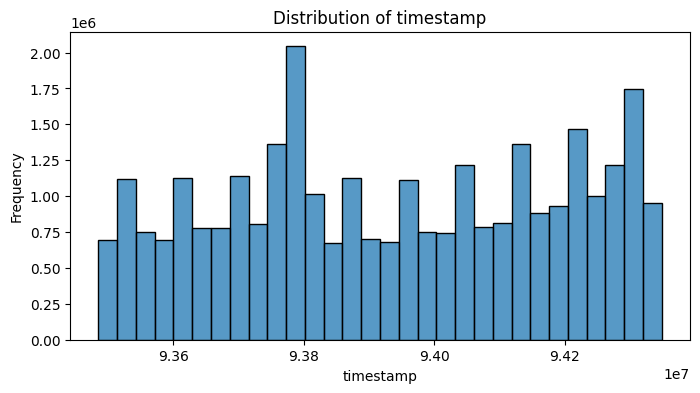

    Skipping distribution plot for user_id (likely an ID with high cardinality).
  - Plotting counts for categorical columns: ['item_id', 'action_type']
    Skipping plot for item_id (too many unique values: 2847)
    Top 10 counts for action_type:
action_type
seen                   29509540
offer_shown              816133
redirect_to_partner      132521
like                      17247
Name: count, dtype: int64


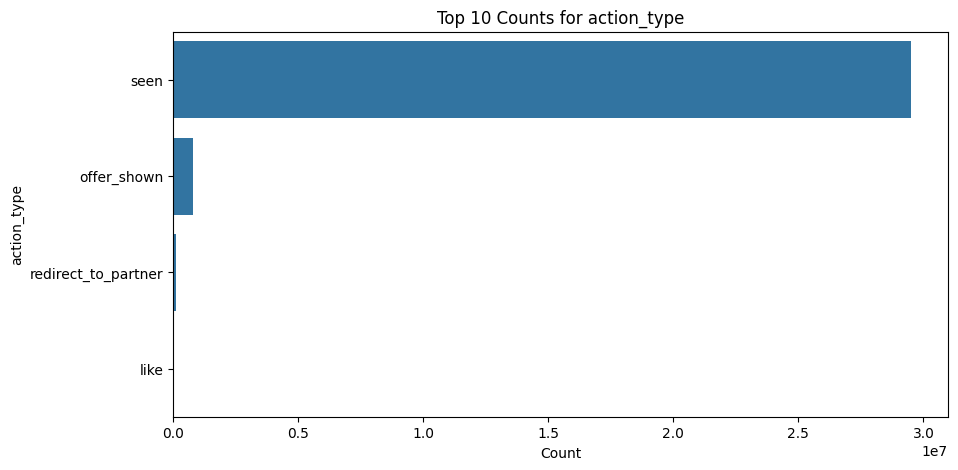

In [12]:
# --- OFFERS EVENTS ---
offers_events_dir = f"{DATASET_PATH_SMALL}/offers/events"
offers_event_files = dataset_files.get(offers_events_dir, [])

df_offers_events = load_dataframe_from_partitions(offers_event_files, limit=DATASET_SMALL_NUM_PARTITIONS_TO_LOAD)
analyze_dataframe(df_offers_events, "Offers Events (Joined)")

## 6. Reviews Domain Analysis
Reviews are partitioned by day directly in the folder.

Loading 10 partitions (out of 227 available)...


c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


  Excluding columns: ['embedding']
  Reading columns: ['timestamp', 'user_id', 'brand_id', 'rating']


c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


  Excluding columns: ['embedding']
  Reading columns: ['timestamp', 'user_id', 'brand_id', 'rating']


c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


  Excluding columns: ['embedding']
  Reading columns: ['timestamp', 'user_id', 'brand_id', 'rating']


c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


  Excluding columns: ['embedding']
  Reading columns: ['timestamp', 'user_id', 'brand_id', 'rating']


c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


  Excluding columns: ['embedding']
  Reading columns: ['timestamp', 'user_id', 'brand_id', 'rating']


c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


  Excluding columns: ['embedding']
  Reading columns: ['timestamp', 'user_id', 'brand_id', 'rating']


c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


  Excluding columns: ['embedding']
  Reading columns: ['timestamp', 'user_id', 'brand_id', 'rating']


c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


  Excluding columns: ['embedding']
  Reading columns: ['timestamp', 'user_id', 'brand_id', 'rating']


c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


  Excluding columns: ['embedding']
  Reading columns: ['timestamp', 'user_id', 'brand_id', 'rating']


c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


  Excluding columns: ['embedding']
  Reading columns: ['timestamp', 'user_id', 'brand_id', 'rating']
Concatenating partitions...

==================== ANALYZING: Reviews (Joined) ====================
Shape: (20508, 4)

1. Head (First 5 rows):


,timestamp,user_id,brand_id,rating
0,1082 days 00:01:05.711723,25741061,141226,5
1,1082 days 00:01:12.026501,71011848,65693,3
2,1082 days 00:02:15.540704,26101012,72285,5
3,1082 days 00:02:25.126055,67977146,184380,3
4,1082 days 00:02:36.993924,4055428,216938,5



2. Info (Data Types & Non-Null Counts):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20508 entries, 0 to 20507
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype          
---  ------     --------------  -----          
 0   timestamp  20508 non-null  timedelta64[us]
 1   user_id    20508 non-null  uint64         
 2   brand_id   20508 non-null  uint64         
 3   rating     20508 non-null  uint8          
dtypes: timedelta64[us](1), uint64(2), uint8(1)
memory usage: 500.8 KB

3. Describe (Statistical Summary for Numeric Columns):


,timestamp,user_id,brand_id,rating
count,20508,2.050800e+04,20508.000000,20508.000000
mean,1086 days 17:32:17.996457,4.546427e+07,122242.731763,4.656476
std,2 days 21:03:34.511318,2.618127e+07,72638.727451,0.864183
min,1082 days 00:01:05.711723,1.029000e+03,163.000000,1.000000
25%,1084 days 08:27:39.607538,2.253189e+07,52475.000000,5.000000
50%,1086 days 11:10:03.739362,4.566062e+07,128326.000000,5.000000
75%,1089 days 08:25:04.180605,6.784836e+07,179630.000000,5.000000
max,1091 days 23:59:49.980192,8.991487e+07,251381.000000,5.000000



4. Missing Values (NaN Count):
timestamp    0
user_id      0
brand_id     0
rating       0
dtype: int64

Missing Percentages:
timestamp    0.0%
user_id      0.0%
brand_id     0.0%
rating       0.0%
dtype: object

5. Duplicates Count:
0

6. Column Value Counts (Top 5 unique values for object columns):

7. Visualizations:
  - Plotting distributions for numeric/timedelta columns: ['timestamp', 'user_id', 'brand_id', 'rating']
    Converting timestamp to total seconds for plotting.
    Distribution statistics for timestamp:
count    2.050800e+04
mean     9.389354e+07
std      2.486145e+05
min      9.348487e+07
25%      9.368806e+07
50%      9.387060e+07
75%      9.411990e+07
max      9.434879e+07
Name: timestamp, dtype: float64


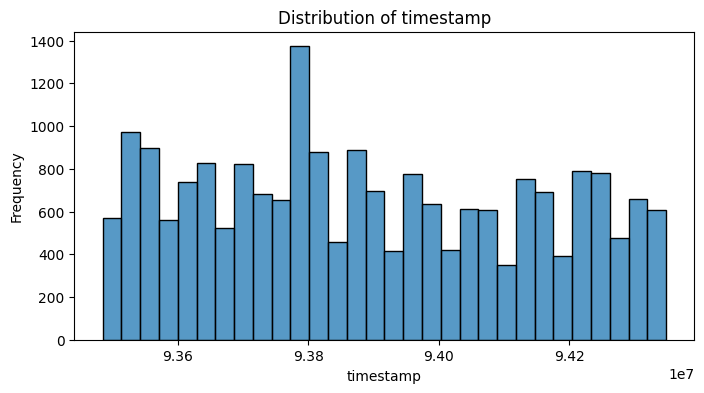

    Skipping distribution plot for user_id (likely an ID with high cardinality).
    Skipping distribution plot for brand_id (likely an ID with high cardinality).
    Distribution statistics for rating:
count    20508.000000
mean         4.656476
std          0.864183
min          1.000000
25%          5.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: rating, dtype: float64


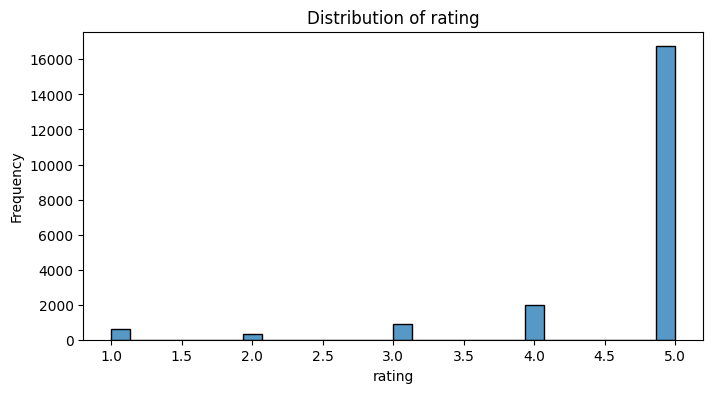

In [13]:
# --- REVIEWS ---
reviews_dir = f"{DATASET_PATH_SMALL}/reviews"
review_files = dataset_files.get(reviews_dir, [])

# Exclude embedding column to avoid schema error
df_reviews = load_dataframe_from_partitions(file_list=review_files, limit=DATASET_SMALL_NUM_PARTITIONS_TO_LOAD, columns_to_exclude=['embedding'])
analyze_dataframe(df_reviews, "Reviews (Joined)")

## 7. Payments Domain Analysis (From 'Full' Dataset)
**Note:** The `payments` data is missing from the `dataset/small` partition. 
We will load a sample from `dataset/full` to ensure we cover this domain in our analysis.

Found 1309 payment event files in FULL dataset. Loading sample...
Filter: Found 1 files matching '01082' (out of 1309)
Loading 1 partitions (out of 1 available)...


c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


Concatenating partitions...

==================== ANALYZING: Payments Events (Sample from Full) ====================
Shape: (68857371, 5)

1. Head (First 5 rows):


,timestamp,user_id,brand_id,price,transaction_hash
0,1082 days 00:00:00.000665,32998228,225785.0,-3.032653,b66e119ab4aec7e7
1,1082 days 00:00:00.004851,50106253,NaN,-1.260849,67e83695d0b5c844
2,1082 days 00:00:00.009371,62366845,NaN,-3.443055,abdea744af9464dd
3,1082 days 00:00:00.010621,47857469,NaN,-4.580940,1a7f10290b300383
4,1082 days 00:00:00.012809,82227054,NaN,0.244966,71c9c652e4508cea



2. Info (Data Types & Non-Null Counts):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68857371 entries, 0 to 68857370
Data columns (total 5 columns):
 #   Column            Dtype          
---  ------            -----          
 0   timestamp         timedelta64[us]
 1   user_id           uint64         
 2   brand_id          float64        
 3   price             float64        
 4   transaction_hash  object         
dtypes: float64(2), object(1), timedelta64[us](1), uint64(1)
memory usage: 2.6+ GB

3. Describe (Statistical Summary for Numeric Columns):


,timestamp,user_id,brand_id,price
count,68857371,6.885737e+07,3.555910e+07,6.885723e+07
mean,1082 days 13:21:35.770560,4.496601e+07,1.197147e+05,-2.544443e+00
std,0 days 06:05:03.303351,2.595342e+07,6.634563e+04,2.637087e+00
min,1082 days 00:00:00.000665,1.000000e+00,0.000000e+00,-1.000000e+01
25%,1082 days 09:09:37.127556,2.248641e+07,5.956600e+04,-4.464495e+00
50%,1082 days 13:56:46.082549,4.496215e+07,1.233090e+05,-2.662108e+00
75%,1082 days 18:07:45.515735,6.743728e+07,1.631780e+05,-1.008714e+00
max,1082 days 23:59:59.994906,8.991871e+07,2.513920e+05,1.000000e+01



4. Missing Values (NaN Count):
timestamp                  0
user_id                    0
brand_id            33298275
price                    139
transaction_hash           0
dtype: int64

Missing Percentages:
timestamp            0.0%
user_id              0.0%
brand_id            48.4%
price                0.0%
transaction_hash     0.0%
dtype: object

5. Duplicates Count:
0

6. Column Value Counts (Top 5 unique values for object columns):

Column: transaction_hash
transaction_hash
372e1f0fea48844f    11
6d82ff4341702bad    10
5a59eda91af402b3    10
785a628331858b98    10
4da1c259e836eb94    10
Name: count, dtype: int64

7. Visualizations:
  - Plotting distributions for numeric/timedelta columns: ['timestamp', 'user_id', 'brand_id', 'price']
    Converting timestamp to total seconds for plotting.
    Distribution statistics for timestamp:
count    6.885737e+07
mean     9.353290e+07
std      2.190330e+04
min      9.348480e+07
25%      9.351778e+07
50%      9.353501e+07
75%      9.3550

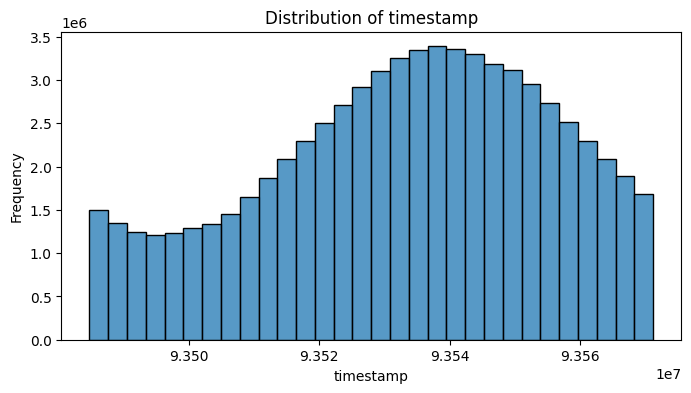

    Skipping distribution plot for user_id (likely an ID with high cardinality).
    Skipping distribution plot for brand_id (likely an ID with high cardinality).
    Distribution statistics for price:
count    6.885723e+07
mean    -2.544443e+00
std      2.637087e+00
min     -1.000000e+01
25%     -4.464495e+00
50%     -2.662108e+00
75%     -1.008714e+00
max      1.000000e+01
Name: price, dtype: float64


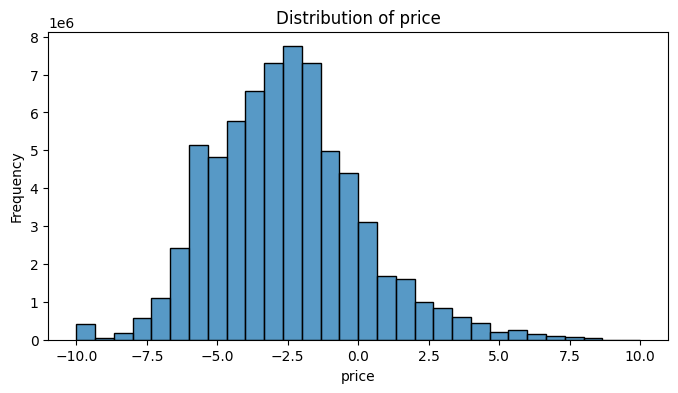

  - Plotting counts for categorical columns: ['transaction_hash']
    Skipping plot for transaction_hash (too many unique values: 59836472)




In [14]:
# --- PAYMENTS EVENTS ---
pay_events_dir = f"{DATASET_PATH_FULL}/payments/events"
pay_events_files = dataset_files.get(pay_events_dir, [])

print(f"Found {len(pay_events_files)} payment event files in FULL dataset. Loading sample...")
df_pay_events = load_dataframe_from_partitions(
    pay_events_files, 
    limit=DATASET_FULL_NUM_PARTITIONS_TO_LOAD,
    match_term=TARGET_PARTITION_ID  # <--- Forces alignment to Day 1082
)
analyze_dataframe(df_pay_events, "Payments Events (Sample from Full)")

Found 1017 payment receipt files in FULL dataset. Loading sample...
Filter: Found 1 files matching '01082' (out of 1017)
Loading 1 partitions (out of 1 available)...


c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\huggingface_hub\utils\_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


Concatenating partitions...

==================== ANALYZING: Payments Receipts (Sample from Full) ====================
Shape: (60753821, 7)

1. Head (First 5 rows):


,timestamp,user_id,brand_id,approximate_item_id,count,price,transaction_hash
0,1082 days 00:00:00.001705,4669811,144881.0,fmcg_256885,1.0,-5.495016,98a0d46e0aedd209
1,1082 days 00:00:00.004234,1393183,NaN,nfmcg_2779189,1.0,-1.591231,55cc577396e77d0e
2,1082 days 00:00:00.005045,20069758,NaN,nfmcg_2928941,1.0,-6.809535,f6540f5416a0fdc2
3,1082 days 00:00:00.006783,39391926,71738.0,nfmcg_26467665,1.0,-3.876979,60ac99a5a49530d1
4,1082 days 00:00:00.010663,13482575,NaN,nfmcg_24354480,1.0,-1.783879,55cc577396e77d0e



2. Info (Data Types & Non-Null Counts):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60753821 entries, 0 to 60753820
Data columns (total 7 columns):
 #   Column               Dtype          
---  ------               -----          
 0   timestamp            timedelta64[us]
 1   user_id              uint64         
 2   brand_id             float64        
 3   approximate_item_id  object         
 4   count                float64        
 5   price                float64        
 6   transaction_hash     object         
dtypes: float64(3), object(2), timedelta64[us](1), uint64(1)
memory usage: 3.2+ GB

3. Describe (Statistical Summary for Numeric Columns):


,timestamp,user_id,brand_id,count,price
count,60753821,6.075382e+07,8.624287e+06,6.075378e+07,5.989202e+07
mean,1082 days 14:02:36.256406,4.484587e+07,1.296697e+05,2.351593e+00,-3.763754e+00
std,0 days 05:58:01.616300,2.594250e+07,7.053562e+04,6.339266e+02,1.722131e+00
min,1082 days 00:00:00.001705,8.000000e+00,1.400000e+01,1.000000e-04,-1.000000e+01
25%,1082 days 10:17:15.768120,2.226728e+07,7.034100e+04,1.000000e+00,-4.864773e+00
50%,1082 days 14:49:43.912271,4.464014e+07,1.307930e+05,1.000000e+00,-3.950519e+00
75%,1082 days 18:36:56.992348,6.736564e+07,1.905960e+05,1.000000e+00,-2.834564e+00
max,1082 days 23:59:59.991880,8.991871e+07,2.513700e+05,9.886270e+05,1.000000e+01



4. Missing Values (NaN Count):
timestamp                     0
user_id                       0
brand_id               52129534
approximate_item_id           0
count                        38
price                    861796
transaction_hash              0
dtype: int64

Missing Percentages:
timestamp               0.0%
user_id                 0.0%
brand_id               85.8%
approximate_item_id     0.0%
count                   0.0%
price                   1.4%
transaction_hash        0.0%
dtype: object

5. Duplicates Count:
0

6. Column Value Counts (Top 5 unique values for object columns):

Column: approximate_item_id
approximate_item_id
nfmcg_14928429    1586064
nfmcg_2927823      391949
nfmcg_12998299     280016
nfmcg_28063153     278068
nfmcg_239196       268132
Name: count, dtype: int64

Column: transaction_hash
transaction_hash
55cc577396e77d0e    30926089
e47b7dc11e026f54         137
3bffbe54ac46ed10         134
d434c9bf91e5188b         133
284be31748113009         132
Name: cou

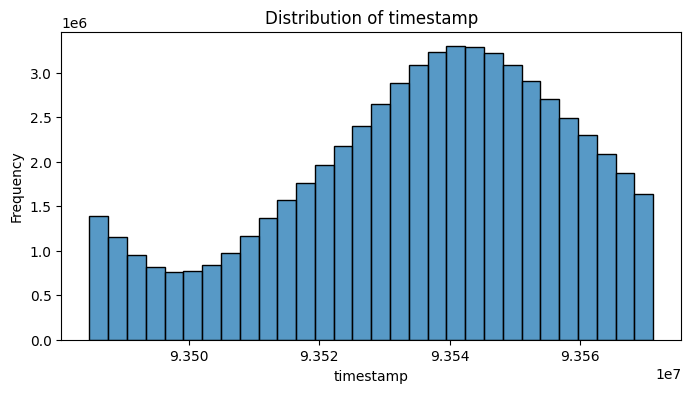

    Skipping distribution plot for user_id (likely an ID with high cardinality).
    Skipping distribution plot for brand_id (likely an ID with high cardinality).
    Distribution statistics for count:
count    6.075378e+07
mean     2.351593e+00
std      6.339266e+02
min      1.000000e-04
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      9.886270e+05
Name: count, dtype: float64


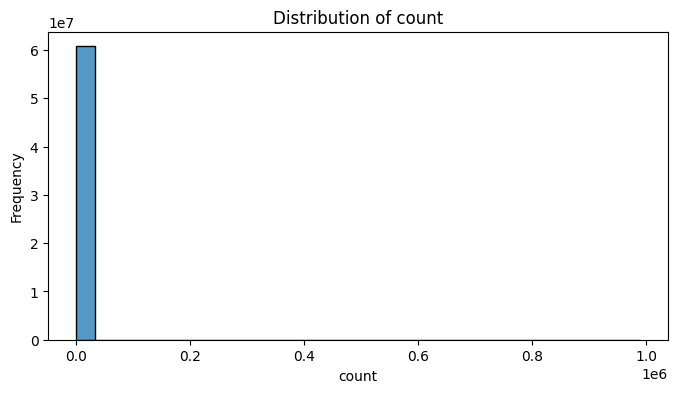

    Distribution statistics for price:
count    5.989202e+07
mean    -3.763754e+00
std      1.722131e+00
min     -1.000000e+01
25%     -4.864773e+00
50%     -3.950519e+00
75%     -2.834564e+00
max      1.000000e+01
Name: price, dtype: float64


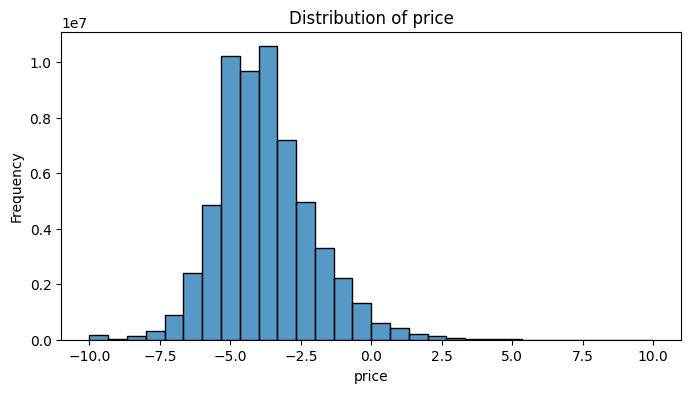

  - Plotting counts for categorical columns: ['approximate_item_id', 'transaction_hash']
    Skipping plot for approximate_item_id (too many unique values: 1071992)
    Skipping plot for transaction_hash (too many unique values: 11286477)




In [15]:
# --- PAYMENTS RECEIPTS ---
pay_receipts_dir = f"{DATASET_PATH_FULL}/payments/receipts"
pay_receipts_files = dataset_files.get(pay_receipts_dir, [])

print(f"Found {len(pay_receipts_files)} payment receipt files in FULL dataset. Loading sample...")
df_pay_receipts = load_dataframe_from_partitions(
    pay_receipts_files, 
    limit=DATASET_FULL_NUM_PARTITIONS_TO_LOAD,
    match_term=TARGET_PARTITION_ID  # <--- Forces alignment to Day 1082
)
analyze_dataframe(df_pay_receipts, "Payments Receipts (Sample from Full)")